# Football match results prediction

The aim of this project is to develop and compare simple Deep Learning models with the ultimate goal of trying to predict the outcomes of *Seria A* football matches, i.e. **home win**, **away win** or **draw**.
In total, three models were designed:
- A **baseline**
- A **hybrid** model
- A **RNN**

Raw data was processed differently based on the target model. Moreover, for each model, two version of processed dataset were generated: the first one including all the available features, the second one just few of them. Each model was trained on both versions of the processed dataset resulting in a total of six trained models.

The following sections will first describe the raw data, then the models and how the raw data was processed for their training.

## The raw data
The raw dataset was gathered from the official [Serie A archive](https://www.legaseriea.it/it/serie-a/archivio). Matches from season 2005-06 to the last one, 2021-22, were considered, each one described by the following features:

In [43]:
import pandas as pd

df = pd.read_csv('raw.csv')
df.shape

(6460, 95)

In [44]:
df.columns

Index(['season', 'round', 'date', 'time', 'referee', 'home_team', 'away_team',
       'home_score', 'away_score', 'home_gk_saves', 'away_gk_saves',
       'home_penalties', 'away_penalties', 'home_shots', 'away_shots',
       'home_shots_on_target', 'away_shots_on_target', 'home_shots_off_target',
       'away_shots_off_target', 'home_shots_on_target_from_penalty_area',
       'away_shots_on_target_from_penalty_area', 'home_fouls', 'away_fouls',
       'home_woodwork_hits', 'away_woodwork_hits', 'home_goal_chances',
       'away_goal_chances', 'home_assists', 'away_assists', 'home_offsides',
       'away_offsides', 'home_corner_kicks', 'away_corner_kicks',
       'home_yel_cards', 'away_yel_cards', 'home_red_cards', 'away_red_cards',
       'home_crosses', 'away_crosses', 'home_long_throws', 'away_long_throws',
       'home_attacks_from_center', 'away_attacks_from_center',
       'home_attacks_from_right', 'away_attacks_from_right',
       'home_attacks_from_left', 'away_attacks_from_l

In [45]:
df.head()

,season,round,date,time,referee,home_team,away_team,home_score,away_score,home_gk_saves,...,away_substitute3,away_substitute4,away_substitute5,away_substitute6,away_substitute7,away_substitute8,away_substitute9,away_substitute10,away_substitute11,away_substitute12
0,2005-06,1,28/08/2005,20:30,MATTEO SIMONE,JUVENTUS,CHIEVOVERONA,1,0,0,...,Amauri,John Mensah,Filippo Antonelli,Victor Obinna,Giovanni Marchese,-,-,-,-,-
1,2005-06,1,28/08/2005,15:00,ROBERTO ROSETTI,REGGINA,ROMA,0,3,0,...,Shabani Nonda,Pietro Pipolo,Cesare Bovo,Houssine Kharja,Antonio Cassano,-,-,-,-,-
2,2005-06,1,28/08/2005,15:00,ANDREA DE,UDINESE,EMPOLI,1,0,4,...,Daniele Balli,Davide Moro,Paolo Zanetti,Andrea Raggi,Francesco Pratali,-,-,-,-,-
3,2005-06,1,28/08/2005,15:00,PAOLO DONDARINI,LAZIO,MESSINA,1,0,7,...,Ivica Iliev,Marco Storari,Filippo Cristante,Luca Fusco,Atsushi Yanagisawa,-,-,-,-,-
4,2005-06,1,28/08/2005,15:00,PAOLO TAGLIAVENTO,INTER,TREVISO,3,0,3,...,Jehad Muntasser,Adriano Zancope,Francesco Parravicini,Anderson,Alberto Giuliatto,-,-,-,-,-


So for each match, we have data about:
- The report (season, round, date, time, referee, teams and scores)
- The statistics (i.e. penalties, shots, shots on target, shots off target, fouls etc.)
- The lineups (coaches, players and substitutes)

Note that we could distinguish between:
- Pre-match data (season, round, date, time, referee, teams and lineups)
- Post-match data (scores and statistics)

As mentioned above, the raw data was processed differently based on the target model, so let's inspect them.

## The models
### The baseline model
The baseline model is a simple Multi-Layer Perceptron that was built with the idea of predicting the outcome of a game just from its pre-match data. Therefore, scores and statistics were not included in the two final datasets as they are unknown at pre-match time.

#### Processing of the raw dataset
##### Phase 1: data fixing
Several matches with some type of issues or inconsistent data were detected and fixed in the raw dataset.

*Example #1*: in several matches played by Lazio during the season 2007-08, the goalkeeper Marco Ballotta is missing in
    the lineup, resulting in a data shift and `NULL` values in the column `away_substitute_12`.

*Example #2*: in round 37, season 2005-06, MESSINA-EMPOLI was suspended at 89’ with score 1-2.
    Then winner of the game was decided to be EMPOLI with a ‘by forfeit’ victory, i.e. 0-3 for EMPOLI.
    Since the game was about to end when it was suspended, the on-pitch score was kept in the dataset.

#### Phase 2: data manipulation
This phase includes few important steps:
- Substitution of `date` and `time` features with `year`, `month`, `day` and `hour`;
- Creation of the target column named `result` based on `home_score` and `away_score`. This column contains the categorical values `home`, `away` or `draw` the model will try to predict;
- Dropping of `home_score`, `away_score` and all the statistics features;
- Type casting

#### Phase 3: data encoding
This phase includes the following steps:
 - Label encoding of `season` and `year` features
 - One-hot encoding of all categorical features

A "simpler" version of this dataset was generated by discarding all the categorical features except for the target column. That is: players, coaches, teams and referees.

### The hybrid model

### The RNN model

<Figure size 432x288 with 0 Axes>

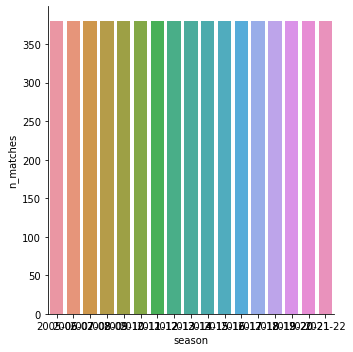

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure()
sns.catplot(x='season', y='n_matches', kind="bar", data=df.groupby('season').size().rename('n_matches').reset_index())
plt.show()